In [16]:
from IPython.core.debugger import set_trace

In [17]:
import torch
from torch import nn, optim

import torchvision
import torchvision.transforms as transforms
import math
import matplotlib.pyplot as plt
import os

In [18]:
torch.manual_seed(111)

In [19]:
device = ''
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')


In [20]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

In [21]:
train_set = torchvision.datasets.MNIST(root='.',
                                      train=True,
                                      download=True,
                                      transform=transform)


In [22]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_set,
                                           batch_size=batch_size,
                                           shuffle=True)

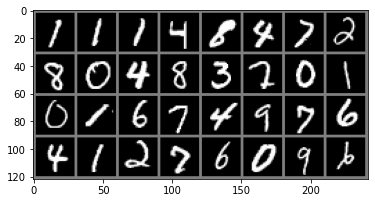

In [23]:
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

real_samples, mnist_labels = next(iter(train_loader))

imshow(torchvision.utils.make_grid(real_samples)) 

In [24]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output

In [25]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh()
        )

    def forward(self, x):
        #x = x.view(x.size(0), 100)
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output

In [26]:
discriminator = Discriminator().to(device=device)

In [27]:
generator = Generator().to(device=device)

In [28]:
lr = 0.0001
num_epochs = 50
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [29]:
latent_space_samples_plot = torch.randn((16, 100)).to(device=device)

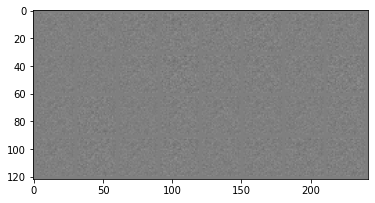

Epoch: 0 Loss D.: 0.7037262916564941
Epoch: 0 Loss G.: 0.693828821182251


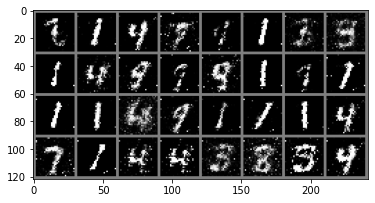

Epoch: 10 Loss D.: 0.4365682005882263
Epoch: 10 Loss G.: 1.714353322982788


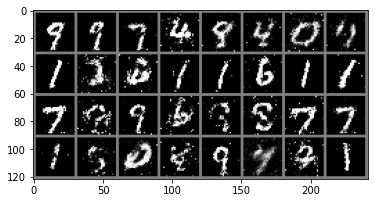

Epoch: 20 Loss D.: 0.4861757159233093
Epoch: 20 Loss G.: 1.2868722677230835


KeyboardInterrupt: ignored

In [30]:
discriminator_loss_plt = []
generator_loss_plt = []

for epoch in range(num_epochs):
    for n, (real_samples, mnist_labels) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples = real_samples.to(device=device)
        real_samples_labels = torch.ones((batch_size, 1)).to(device=device)
        latent_space_samples = torch.randn((batch_size, 100)).to(device=device)
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros(
            (batch_size, 1)).to(device=device)
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels))

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        discriminator_loss_plt.append(loss_discriminator.item())
    
        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 100)).to(device=device)

        # Training the generator            
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels)
        loss_generator.backward()
        optimizer_generator.step() 

        generator_loss_plt.append(loss_generator.item())

        if epoch % 10 == 0 and n == 0:
          imshow(torchvision.utils.make_grid(generated_samples.cpu().detach()))
          # Show loss
          print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
          print(f"Epoch: {epoch} Loss G.: {loss_generator}")

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(discriminator_loss_plt, label='Discriminator loss')
plt.plot(generator_loss_plt, label='Generator loss')
plt.legend()
plt.grid()
plt.show()